In [4]:
%matplotlib inline
import os
from tqdm import tqdm
###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy.sparse import *
import nltk
import random
###
import networkx as nx
from node2vec import Node2Vec
from gensim.models import word2vec
###
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

In [5]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chene\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chene\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Info of the graph
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] =  graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] =  np.min(degrees) # minimum degree
    prop['max_degree'] =  np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] =  nx.density(graph) # density of the graph
    return prop

# Turning the training data into a graph

In [7]:
def get_training_graph(csv_file, column_names=['source', 'target', 'connected']):

    # Pandas dataframe
    df = pd.read_csv(csv_file, sep=' ', names=column_names)
    edges = df.loc[df['connected'] == 1]

    # Number of edges
    print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

    # networkx graph
    Graphtype = nx.DiGraph()
    G = nx.from_pandas_edgelist(edges, create_using=Graphtype)
    
    return G

In [8]:
training_graph = get_training_graph('training_set.txt')

There are 335130 edges and 280382 non edges


In [9]:
compute_network_characteristics(graph=training_graph)

{'N': 27684,
 'M': 335130,
 'min_degree': 1,
 'max_degree': 2346,
 'mean_degree': 24.211096662332032,
 'median_degree': 14.0,
 'density': 0.0004372917794735403}

## For now let's focus on a smaller graph

In [10]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

In [11]:
random.seed(10)
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.5)))
training_set_reduced = [training_set[i] for i in to_keep]

In [12]:
# Pandas dataframe
df = pd.DataFrame(training_set_reduced, columns=['source', 'target', 'connected'])
edges = df.loc[df['connected'] == '1']

# Number of edges
print(f'There are {len(edges)} edges and {len(df) - len(edges)} non edges')

# networkx graph !!!!!!! The graph is directed
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(edges, create_using=Graphtype)

# Take the largest weakly conected component
nodes = max(nx.strongly_connected_components(G), key=len) 
G0 = G.subgraph(nodes)


nx.is_weakly_connected(G0)

There are 167561 edges and 140195 non edges


True

In [13]:
compute_network_characteristics(G0)

{'N': 3168,
 'M': 22513,
 'min_degree': 2,
 'max_degree': 470,
 'mean_degree': 14.212752525252526,
 'median_degree': 11.0,
 'density': 0.0022438826216060193}

## Generate Samples

In [14]:
def real_labels(graph, samples):
    labels = []
    for edge in tqdm(samples):
        if edge in graph.edges():
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [15]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_weakly_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in tqdm(edges):
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_weakly_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    random.seed(10)
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = real_labels(G, test_samples) # !!!! G et pas G0
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


In [16]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(G0, train_set_ratio=0.8)

 20%|███████████████▏                                                            | 4511/22513 [01:01<02:46, 108.04it/s]

# Random Walk (feature extraction directed graph)

In [17]:
def feature_extractor_walk(graph, samples, node2embedding, dimension, feature_func = None):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """    
    # --- Construct feature vectors for edges ---
    if feature_func is None:
        feature_func = lambda x,y: abs(x-y)

    # Fill in the blanks
    feature_vector = []
    for edge in samples:
        source_node = edge[0]
        target_node = edge[1]
        
        try:
            source_embedding = node2embedding[source_node]

        except KeyError:
            source_embedding = np.ones(dimension)
            
        try:
            target_embedding = node2embedding[target_node]
        except KeyError:
            target_embedding = np.ones(dimension)
            
        feature_vector.append(feature_func(source_embedding, target_embedding))
        
    return np.array(feature_vector)

## Best embedding model

In [89]:
num_of_walks = 100
walk_length = 30
embedding_size = 256
window_size = 10

node2vec = Node2Vec(residual_g, dimensions=embedding_size, walk_length=walk_length,
                    num_walks=num_of_walks, workers=4)
# Embed nodes
model = node2vec.fit(window=window_size, min_count=1, batch_words=4)

In [98]:
model.wv.save('node2vec.wordvectors')

In [18]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load("node2vec.wordvectors", mmap='r')

In [20]:
num_of_walks = 100
walk_length = 30
embedding_size = 256
window_size = 10

train_features = feature_extractor_walk(G0, train_samples, wv, embedding_size)
test_features = feature_extractor_walk(G0, test_samples, wv, embedding_size)

# --- Build the model and train it ---
# Fill in the blanks
clf = LogisticRegression()
clf.fit(train_features, train_labels)

train_preds = clf.predict_proba(train_features)[:, 1]
test_preds = clf.predict_proba(test_features)[:, 1]
labels_pred = clf.predict(test_features)

print(f'Accuracy: {accuracy_score(test_labels, labels_pred)}')
print(f'F1 score: {f1_score(test_labels, labels_pred)}')

# --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
# Fill in the blanks
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

Accuracy: 0.8294091514882275
F1 score: 0.8327161838379438
0.9054955781536258


## Feature extraction undirected graph

In [21]:
def feature_extractor_undirected(graph, samples, deg_centrality):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    number_nodes_out = 0

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        if (source_node not in list(deg_centrality.keys())) or (target_node not in list(deg_centrality.keys())):
            feature_vector.append(np.array([0, 0, 0, 0, 0, 0]))
            number_nodes_out += 1

        else:

            source_degree_centrality = deg_centrality[source_node]
            target_degree_centrality = deg_centrality[target_node]
#             source_katz_cent = katz_cent[source_node]
#             target_katz_cent = katz_cent[target_node]
            
            # # Betweeness centrality measure 
            #diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

            # Preferential Attachement 
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

            # AdamicAdar
            aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

            # Jaccard
            jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
            # Ressource allocation index
            res_all = list(nx.resource_allocation_index(graph, [(source_node, target_node)]))[0][2]
            
            # Create edge feature vector with all metric computed above
            feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, pref_attach, aai, jacard_coeff, res_all]) ) 
    print(number_nodes_out)
        
    return np.array(feature_vector)

In [25]:
G_undirected = G0.to_undirected()
print("degree centrality")
deg_centrality = nx.degree_centrality(G_undirected)
print("done!")
train_features_undirected = feature_extractor_undirected(G_undirected, train_samples, deg_centrality)
test_features_undirected = feature_extractor_undirected(G_undirected, test_samples, deg_centrality)

degree centrality
done!



100%|██████████████████████████████████████████████████████████████████████████| 36022/36022 [00:10<00:00, 3321.29it/s]

0



100%|████████████████████████████████████████████████████████████████████████████| 9004/9004 [00:02<00:00, 3271.56it/s]

0


In [26]:
###Merge features
train_features = np.concatenate([train_features,train_features_undirected],axis=1)
test_features = np.concatenate([test_features,test_features_undirected],axis=1)

# Adding additional information

In [7]:
column_names = ['id', 'year', 'title', 'authors', 'journal', 'abstract']
info = pd.read_csv('node_information.csv', sep=',', names=column_names)
info.head()

,id,year,title,authors,journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [16]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
abstracts = [element[5] for element in node_info]

In [17]:
abstracts_w = [element.lower().split() for element in abstracts]

In [13]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

model_embedding = word2vec.Word2Vec(abstracts_w, workers=num_workers, size=num_features, 
                                    min_count = min_word_count, window = context, sample = downsampling)

In [29]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords += 1.
            featureVec += model[word]
    # 
    # Divide the result by the number of words to get the average
    featureVec = featureVec/nwords
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for i,review in enumerate(reviews):
        if i%1000. ==0.:
            print("Review %d of %d" % (i, len(reviews)))
        reviewFeatureVecs[i] = makeFeatureVec(review, model, num_features)
        
       
    return reviewFeatureVecs

In [18]:
abstracts_stp =  [[word for word in element.split(" ") if word.lower() not in stpwds] for element in abstracts ]

In [30]:
model_embedding.init_sims(replace=True)
DataVecs = getAvgFeatureVecs( abstracts_stp, model_embedding, num_features )

Review 0 of 27770


C:\Users\chene\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 27770
Review 2000 of 27770
Review 3000 of 27770
Review 4000 of 27770
Review 5000 of 27770
Review 6000 of 27770
Review 7000 of 27770
Review 8000 of 27770
Review 9000 of 27770
Review 10000 of 27770
Review 11000 of 27770
Review 12000 of 27770
Review 13000 of 27770
Review 14000 of 27770
Review 15000 of 27770
Review 16000 of 27770
Review 17000 of 27770
Review 18000 of 27770
Review 19000 of 27770
Review 20000 of 27770
Review 21000 of 27770
Review 22000 of 27770
Review 23000 of 27770
Review 24000 of 27770
Review 25000 of 27770
Review 26000 of 27770
Review 27000 of 27770


In [29]:
vect = TfidfVectorizer(stop_words="english")
abstract_vectorized = vect.fit_transform(info['abstract'])

In [31]:
def isselfcite(source_auth, target_auth): 
    selfcite = 0
    for sauth in source_auth: 
        if sauth in target_auth: 
            selfcite = 1
            break 
    return selfcite

def issamejournal(source_journal, target_journal): 
    
    if source_journal == target_journal: 
        same_journal = 1
    else:
        same_journal = 0
    return same_journal
        
        
def cosine_similarity(s_1, s_2): 
    #remove stopwords 
    s_1 = np.reshape(s_1,(1,-1)  )
    s_2 = np.reshape(s_2,(1,-1)  )
    return cosine(s_1,s_2)

In [34]:
def processing_info(sample, DataVecs):
    overlap_title = []

    # temporal distance between the papers
    temp_diff = []

    # number of common authors
    comm_auth = []

    #is self citation
    self_cite = []

    #is published in same journal 
    same_journal = []

    #cosine  similarity 
    cosine_sim = []

    counter = 0
    for i in range(len(sample)):
        source = sample[i][0]
        target = sample[i][1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)

        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]

        # convert to lowercase and tokenize
        source_title = source_info[2].lower().split(" ")
        # remove stopwords
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]

        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]

        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")

        source_journal = source_info[4].lower()
        target_journal = target_info[4].lower()

        source_abstract = DataVecs[index_source]
        target_abstract = DataVecs[index_target]


        overlap_title.append(len(set(source_title).intersection(set(target_title))))
        temp_diff.append(int(source_info[1]) - int(target_info[1]))
        comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
        self_cite.append(isselfcite(source_auth,target_auth))
        same_journal.append(issamejournal(source_journal, target_journal))
        cosine_sim.append(cosine_similarity(source_abstract, target_abstract))

        counter += 1
        if counter % 1000 == True:
            print("training examples processsed", counter)
            
    return overlap_title, temp_diff, comm_auth, self_cite, same_journal, cosine_sim

In [30]:
def preprocessing_info(sample, abstract_vectorized):
    # number of overlapping words in title
    overlap_title = []

    # temporal distance between the papers
    temp_diff = []

    # number of common authors
    comm_auth = []

    # Cosine sim between abstracts
    cosine_sim = []

    dense_matrix = abstract_vectorized.todense()

    counter = 0
    for i in range(len(sample)):
        source = sample[i][0]
        target = sample[i][1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_info = [element for element in node_info if element[0]==source][0]
        target_info = [element for element in node_info if element[0]==target][0]
        
        # convert to lowercase and tokenize
        source_title = source_info[2].lower().split(" ")
        # remove stopwords
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]
        
        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
        
        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        
        overlap_title.append(len(set(source_title).intersection(set(target_title))))
        temp_diff.append(int(source_info[1]) - int(target_info[1]))
        comm_auth.append(len(set(source_auth).intersection(set(target_auth))))

        v1 = dense_matrix[index_source,:]
        v2 = dense_matrix[index_target,:]

        sim = cosine_similarity(v1, v2)
        cosine_sim.append(sim[0][0])
    
        counter += 1
        if counter % 1000 == True:
            print(counter, "training examples processsed")

    return overlap_title, temp_diff, comm_auth, cosine_sim

In [35]:
overlap_title_train, temp_diff_train, comm_auth_train, cosine_sim_train = processing_info(train_samples, DataVecs)

NameError: name 'train_samples' is not defined

In [32]:
overlap_title_test, temp_diff_test, comm_auth_test, cosine_sim_test = preprocessing_info(test_samples, abstract_vectorized)

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed


In [33]:
def get_training_features(overlap_title, temp_diff, comm_auth, sim):
    training_features = np.array([overlap_title, temp_diff, comm_auth, sim]).T
    #training_features = preprocessing.scale(training_features)
    df = pd.DataFrame(training_features, columns=['overl_title', 'temp_diff', 'comm_author', 'sim'])
    return training_features, df

In [34]:
training_add_feat = get_training_features(overlap_title_train, temp_diff_train, comm_auth_train, cosine_sim_train)[1]
testing_add_feat = get_training_features(overlap_title_test, temp_diff_test, comm_auth_test, cosine_sim_test)[1]

In [35]:
all_train_feat = np.concatenate([train_features, training_add_feat.to_numpy()], axis=1)
all_test_feat = np.concatenate([test_features, testing_add_feat.to_numpy()], axis=1)

In [36]:
def prediction(train_samples, test_samples, train_labels, test_labels):
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = svm.LinearSVC(max_iter=50000)
    clf.fit(train_samples, train_labels)

    train_preds = clf.decision_function(train_samples)
    test_preds = clf.decision_function(test_samples)
    
    labels_pred = clf.predict(test_samples)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    print(f'Accuracy: {accuracy_score(test_labels, labels_pred)}')
    print(f'F1 score: {f1_score(test_labels, labels_pred)}')
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

C:\Users\chene\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.9093736117281208
F1 score: 0.9053803339517625


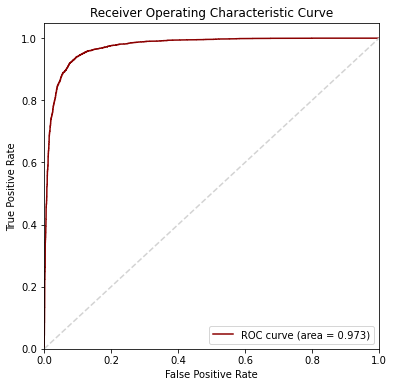

0.9732795099112868

In [37]:
prediction(all_train_feat, all_test_feat, train_labels, test_labels)

# Getting the features of the test set

In [38]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

In [57]:
overlap_title_test = []
temp_diff_test = []
comm_auth_test = []
cosine_sim_test = []
dense_matrix = abstract_vectorized.todense()
   
counter = 0
for i in range(len(testing_set)):

    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))

    v1 = dense_matrix[index_source,:]
    v2 = dense_matrix[index_target,:]

    sim = cosine_similarity(v1, v2)
    cosine_sim_test.append(sim[0][0])
   
    counter += 1
    if counter % 1000 == True:
        print(counter, "testing examples processsed")

1 testing examples processsed
1001 testing examples processsed
2001 testing examples processsed
3001 testing examples processsed
4001 testing examples processsed
5001 testing examples processsed
6001 testing examples processsed
7001 testing examples processsed
8001 testing examples processsed
9001 testing examples processsed
10001 testing examples processsed
11001 testing examples processsed
12001 testing examples processsed
13001 testing examples processsed
14001 testing examples processsed
15001 testing examples processsed
16001 testing examples processsed
17001 testing examples processsed
18001 testing examples processsed
19001 testing examples processsed
20001 testing examples processsed
21001 testing examples processsed
22001 testing examples processsed
23001 testing examples processsed
24001 testing examples processsed
25001 testing examples processsed
26001 testing examples processsed
27001 testing examples processsed
28001 testing examples processsed
29001 testing examples proc

In [58]:
testing_features = np.array([overlap_title_test,temp_diff_test,comm_auth_test, cosine_sim_test]).T
testing_features = preprocessing.scale(testing_features)

In [59]:
test_feat = pd.DataFrame(testing_features, columns=['overl_title', 'temp_diff', 'comm_author', 'sim'])

In [60]:
test_feat = pd.read_csv('test_text_feat.csv').to_numpy()[:,1:]

In [40]:
test_graph_undirected = feature_extractor_undirected(G_undirected, testing_set, deg_centrality)


100%|██████████████████████████████████████████████████████████████████████████| 32648/32648 [00:05<00:00, 6121.15it/s]

30242


In [42]:
test_graph_feat = feature_extractor_walk(G0, testing_set, wv, embedding_size)

In [43]:
test_graph_feat = np.concatenate([test_graph_feat,test_graph_undirected],axis=1)

In [62]:
total_test_feat = np.concatenate([test_graph_feat, test_feat], axis=1)

In [63]:
total_test_feat.shape

(32648, 266)

In [50]:
all_train_feat.shape

(36022, 266)

In [46]:
# initialize basic SVM
classifier = svm.LinearSVC()
# train
classifier.fit(all_train_feat, train_labels)

C:\Users\chene\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [64]:
predictions_SVM = list(classifier.predict(total_test_feat))

predictions_SVM = list(zip(range(len(testing_set)), predictions_SVM))

In [109]:
with open("test_strongly_connected.csv","w", newline='') as pred1:
    csv_out = csv.writer(pred1)
    for row in predictions_SVM:
        csv_out.writerow(row)
        
        

In [67]:
prediction_svm = pd.DataFrame(predictions_SVM,columns=['id','category']) 

In [68]:
prediction_svm.to_csv('pred_node_embedding_undirected.csv',index=False)